custom mesolve attempt

In [2]:
import numpy as np
import scipy.integrate
from qutip.qobj import Qobj, isket, isoper, issuper
from qutip.superoperator import spre, spost, liouvillian, vec2mat, lindblad_dissipator
from qutip.expect import expect_rho_vec
from qutip.solver import Options, Result, solver_safe, SolverSystem
from qutip.cy.spmatfuncs import spmv
from qutip.cy.spconvert import dense2D_to_fastcsr_fmode
from qutip.states import ket2dm
from qutip.sesolve import sesolve
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar
from qutip.qobjevo import QobjEvo

from qutip.cy.openmp.utilities import check_use_openmp

from transmon import Transmon
from gates import Gate
import pickle
import matplotlib.pyplot as plt

In [3]:
tr = Transmon(3, 0, 5000, -350)
X180 = Gate("X", 180)
t = np.linspace(0, 1, 1000)
opt = Options(store_states=True)

tr.ψ0 = ket2dm(tr.ψ0)

In [4]:
with open("f2", 'rb') as f:
    optimal_params = pickle.load(f)

X180.optimal_parameters = optimal_params[0]

In [5]:
args = X180.optimal_parameters
H = [tr.H0, [tr.H1, np.array(X180.H1_coeffs(t, args))]]
H = [tr.H1, np.array(X180.H1_coeffs(t, args))]

# H = [tr.H0, [tr.H1, X180.H1_coeffs]]

In [6]:
# H_td = QobjEvo(H, args, tlist=t)
H_td = QobjEvo(H, tlist=t)
L_td = liouvillian((H_td))

In [7]:
for op in tr.c_ops:
    if isinstance(op, Qobj):
        op_td = QobjEvo(op)
    elif isinstance(op, QobjEvo):
        op_td = QobjEvo(op, args)
    else:
        op_td = QobjEvo(op, args, tlist=t)
    if not issuper(op_td.cte):
        op_td = lindblad_dissipator(op_td)
    L_td += op_td


In [8]:
def _generic_ode_solve(func, ode_args, rho0, tlist, e_ops, opt,
                       progress_bar, dims=None):
    """
    Internal function for solving ME.
    Calculate the required expectation values or invoke
    callback function at each time step.
    """
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # This function is made similar to sesolve's one for futur merging in a
    # solver class
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    # prepare output array
    n_tsteps = len(tlist)
    output = Result()
    output.solver = "mesolve"
    output.times = tlist
    size = rho0.shape[0]

    initial_vector = rho0.full().ravel('F')

    r = scipy.integrate.ode(func)
    r.set_integrator('zvode', method=opt.method, order=opt.order,
                     atol=opt.atol, rtol=opt.rtol, nsteps=opt.nsteps,
                     first_step=opt.first_step, min_step=opt.min_step,
                     max_step=opt.max_step)
    if ode_args:
        r.set_f_params(*ode_args)
    r.set_initial_value(initial_vector, tlist[0])

    e_ops_data = []
    output.expect = []
    if callable(e_ops):
        n_expt_op = 0
        expt_callback = True
        output.num_expect = 1
    elif isinstance(e_ops, list):
        n_expt_op = len(e_ops)
        expt_callback = False
        output.num_expect = n_expt_op
        if n_expt_op == 0:
            # fall back on storing states
            opt.store_states = True
        else:
            for op in e_ops:
                if not isinstance(op, Qobj) and callable(op):
                    output.expect.append(np.zeros(n_tsteps, dtype=complex))
                    continue
                if op.dims != rho0.dims:
                    raise TypeError(f"e_ops dims ({op.dims}) are not "
                                    f"compatible with the state's "
                                    f"({rho0.dims})")
                e_ops_data.append(spre(op).data)
                if op.isherm and rho0.isherm:
                    output.expect.append(np.zeros(n_tsteps))
                else:
                    output.expect.append(np.zeros(n_tsteps, dtype=complex))
    else:
        raise TypeError("Expectation parameter must be a list or a function")

    if opt.store_states:
        output.states = []

    def get_curr_state_data(r):
        return vec2mat(r.y)

    #
    # start evolution
    #
    dt = np.diff(tlist)
    cdata = None
    progress_bar.start(n_tsteps)
    for t_idx, t in enumerate(tlist):
        progress_bar.update(t_idx)

        if not r.successful():
            raise Exception("ODE integration error: Try to increase "
                            "the allowed number of substeps by increasing "
                            "the nsteps parameter in the Options class.")

        if opt.store_states or expt_callback:
            cdata = get_curr_state_data(r)
            fdata = dense2D_to_fastcsr_fmode(cdata, size, size)

            # Try to guess if there is a fast path for rho_t
            if issuper(rho0) or not rho0.isherm:
                rho_t = Qobj(fdata, dims=dims)
            else:
                rho_t = Qobj(fdata, dims=dims, fast="mc-dm")

        if opt.store_states:
            output.states.append(rho_t)

        if expt_callback:
            # use callback method
            output.expect.append(e_ops(t, rho_t))

        for m in range(n_expt_op):
            if not isinstance(e_ops[m], Qobj) and callable(e_ops[m]):
                output.expect[m][t_idx] = e_ops[m](t, rho_t)
                continue
            output.expect[m][t_idx] = expect_rho_vec(e_ops_data[m], r.y,
                                                     e_ops[m].isherm
                                                     and rho0.isherm)

        if t_idx < n_tsteps - 1:
            r.integrate(r.t + dt[t_idx])

    progress_bar.finished()

    if opt.store_final_state:
        cdata = get_curr_state_data(r)
        output.final_state = Qobj(cdata, dims=dims,
                                  isherm=rho0.isherm or None)

    return output

In [9]:
def _test_liouvillian_dimensions(L_dims, rho_dims):
    """
    Raise ValueError if the dimensions of the Liouvillian and the density
    matrix or superoperator state are incompatible with the master equation.
    """
    if L_dims[0] != L_dims[1]:
        raise ValueError("Liouvillian had nonsquare dims: " + str(L_dims))
    if not ((L_dims[1] == rho_dims) or (L_dims[1] == rho_dims[0])):
        raise ValueError("".join([
            "incompatible Liouvillian and state dimensions: ",
            str(L_dims), " and ", str(rho_dims),
        ]))

def _qobjevo_set(HS, rho0, args, e_ops, opt):
    """
    From the system, get the ode function and args
    """
    H_td = HS.H
    H_td.solver_set_args(args, rho0, e_ops)
    if issuper(rho0):
        func = H_td.compiled_qobjevo.ode_mul_mat_f_vec
    elif rho0.isket or rho0.isoper:
        func = H_td.compiled_qobjevo.mul_vec
    else:
        # Should be caught earlier in mesolve.
        raise ValueError("rho0 must be a ket, density matrix or superoperator")
    
    _test_liouvillian_dimensions(H_td.cte.dims, rho0.dims)
    return func, ()

In [10]:
nthread = opt.openmp_threads if opt.use_openmp else 0

L_td.compile(omp=nthread)

ss = SolverSystem()
ss.H = L_td
ss.makefunc = _qobjevo_set
solver_safe["mesolve"] = ss

# ss is now defined

In [11]:
func, ode_args = ss.makefunc(ss, tr.ψ0, args, tr.e_ops, opt)

res = _generic_ode_solve(func, ode_args, tr.ψ0, t, tr.e_ops, opt, progress_bar=BaseProgressBar(), dims=tr.ψ0.dims)

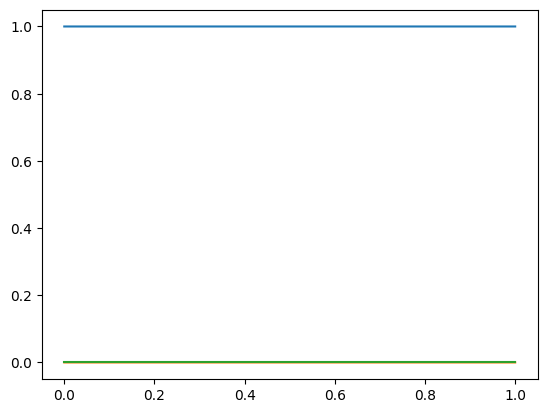

In [12]:
[plt.plot(t, i) for i in res.expect]
plt.show()